### This notebook deals with the improvements of the titanic survival prediction

# 1. Setup data

In [2]:
import pandas as pd
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# 2. Data Exploration and pre-processing

A case of accident is being discussed. By a natural understanding, 'Name' won't have any effect on the nature of survival. Therefore, 'Name' has to be dropped.


In [2]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
features_train = train_df.drop(['Name'], axis = 1)
features_test = test_df.drop(['Name'], axis = 1)

### 2.1 Missing data

Age could be a factor which would affect the survival. It is missing in 19% of data, we can simply drop those records.
Cabin is missing in a lot of records almost 77% records. We can treat it as NA.
2 records of EMbarked can be dropped

In [4]:
total1 = features_train.isnull().sum().sort_values(ascending = False)
percent1 = (features_train.isnull().sum()/features_train.isnull().count()).sort_values(ascending = False)
missingData_df_train = pd.concat([total1,percent1], axis = 1)
missingData_df_train

,0,1
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000
Survived,0,0.000000


In [5]:
total2 = features_test.isnull().sum().sort_values(ascending = False)
percent2 = (features_test.isnull().sum()/features_test.isnull().count()).sort_values(ascending = False)
missingData_df_test = pd.concat([total2,percent2], axis = 1)
missingData_df_test

,0,1
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Pclass,0,0.000000
PassengerId,0,0.000000


In [6]:
#drop Age
features_train.drop(features_train[features_train.Age.isnull()].index.tolist(), axis = 0, inplace = True)
features_test.Age.fillna(features_test.Age.mean, inplace=True)

features_train.Cabin.fillna('NA', inplace = True)
features_test.Cabin.fillna('NA', inplace = True)

features_train.drop(features_train[features_train.Embarked.isnull()].index.tolist(), axis = 0, inplace = True)
features_test.Fare.fillna(features_test.Fare.mean, inplace=True)

### 2.2 Ensuring uniformity of unique values in categorical variables

For SibSp (Number of siblings/spouses) we have a value of 8 for 1 record in Test set. This value is not present in the training set.
We consider this number as highest, so we update it to the highest value in the training set so that it would be considered 

Cabin has too many unique values to be considered as a categorical variable.
But the level of the cabin can be a useful feature. Se we strip only the first letter of the Cabin.

In [7]:
train_unique = features_train.SibSp.unique().tolist()
test_unique = features_test.SibSp.unique().tolist()
train_unique.sort()
test_unique.sort()
print(train_unique, '\n', test_unique)


[0, 1, 2, 3, 4, 5] 
 [0, 1, 2, 3, 4, 5, 8]


In [8]:
train_unique = features_train.Parch.unique().tolist()
test_unique = features_test.Parch.unique().tolist()
train_unique.sort()
test_unique.sort()
print(train_unique, '\n', test_unique)

[0, 1, 2, 3, 4, 5, 6] 
 [0, 1, 2, 3, 4, 5, 6, 9]


In [9]:
features_test.loc[features_test['SibSp'] == 8, 'SibSp'] = 5
features_test.loc[features_test['Parch'] == 9, 'Parch'] = 6

In [10]:
features_train['Cabin_level'] = features_train['Cabin'].apply(lambda passenger: passenger[0])
features_test['Cabin_level'] = features_test['Cabin'].apply(lambda passenger: passenger[0])

# 3. Feature Selection

### 3.1 Getting the dummy variables/ one hot encoded variables

A problem arises when there are different unique values for a categorical variable in training and test sets.
Therefore it is advised to combine both the sets and then perform the encoding operation.

In [11]:
features_train['set_type'] = 'train'
features_test['set_type'] = 'test'
feature_columns = ['set_type', 'PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_level', 'Embarked', 'Survived']

combined_df = pd.concat([features_train[feature_columns], features_test[feature_columns[:-1]]], ignore_index=True)
combined_df.head()

,set_type,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_level,Embarked,Survived
0,train,1,3,male,22,1,0,7.25,N,S,0.0
1,train,2,1,female,38,1,0,71.2833,C,C,1.0
2,train,3,3,female,26,0,0,7.925,N,S,1.0
3,train,4,1,female,35,1,0,53.1,C,S,1.0
4,train,5,3,male,35,0,0,8.05,N,S,0.0


In [12]:
Xformed_df = pd.get_dummies(combined_df, 
                   prefix_sep='_',
                   dummy_na=False,
                   columns=['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin_level', 'Embarked'],
                   drop_first=True)

In [13]:
Xformed_train_df = Xformed_df.loc[Xformed_df['set_type'] == 'train'].iloc[:,1:]
Xformed_test_df = Xformed_df.loc[Xformed_df['set_type'] == 'test'].iloc[:,1:]
Xformed_test_df.drop(['Survived'], axis = 1, inplace=True)

In [14]:
X_train = Xformed_train_df.drop(['Survived'], axis = 1)
y_train = Xformed_train_df['Survived']

### 3.2 Select the features
#### 3.2.1 Study Correlation

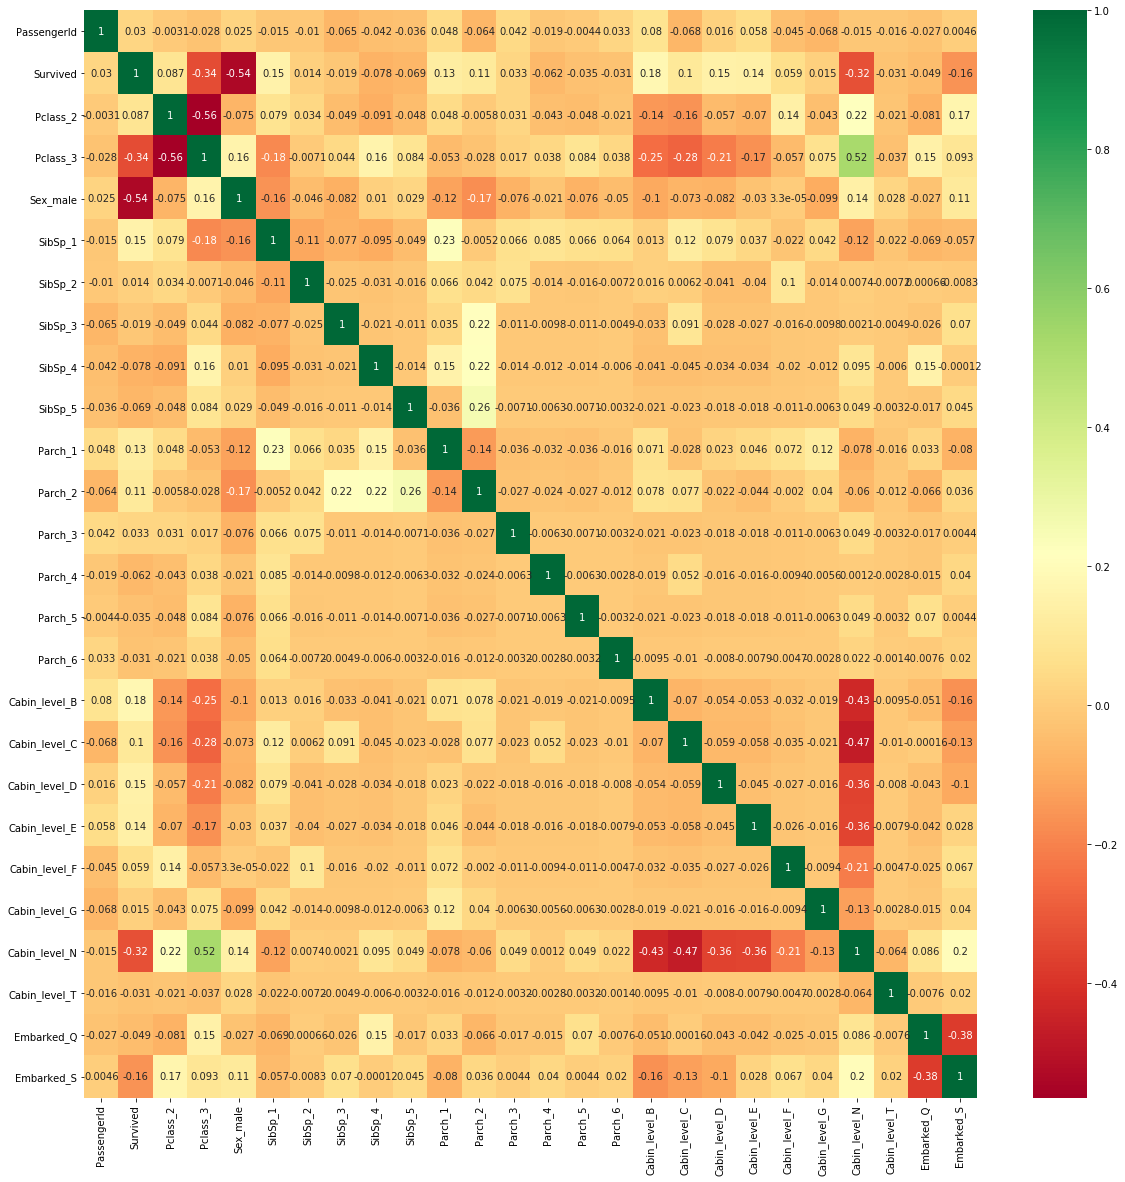

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = Xformed_train_df.corr()
top_corr_features = corr_matrix.index

#plot heat map
plt.figure(figsize=(20,20))
graph = sns.heatmap(Xformed_train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [16]:
featuresSelected1 = corr_matrix['Survived'].sort_values(ascending = False).head(12).index.tolist()[1:]

In [17]:
#Check if features selected are highly correlated
corr_matrix2 = Xformed_train_df[featuresSelected1].corr()
corr_matrix2.describe()

,Cabin_level_B,SibSp_1,Cabin_level_D,Cabin_level_E,Parch_1,Parch_2,Cabin_level_C,Pclass_2,Cabin_level_F,Parch_3,PassengerId
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.078845,0.143979,0.076032,0.075103,0.121210,0.076736,0.063681,0.078400,0.092287,0.089565,0.095315
std,0.313384,0.293021,0.309302,0.309976,0.304893,0.312076,0.319405,0.318653,0.306239,0.303752,0.304157
min,-0.143632,-0.021558,-0.059264,-0.069920,-0.138902,-0.138902,-0.157367,-0.157367,-0.045176,-0.035948,-0.067529
25%,-0.053632,0.003785,-0.049420,-0.048961,-0.002632,-0.035846,-0.063397,-0.063302,-0.029243,-0.022340,-0.030166
50%,-0.021320,0.066004,-0.022496,-0.026273,0.047551,-0.005821,-0.034795,-0.003142,-0.021558,-0.017638,0.015994
75%,0.074586,0.101272,0.019524,0.041188,0.071780,0.037280,0.026579,0.063361,0.035264,0.036640,0.052839
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 3.2.2 Select K-Best

In [18]:
from sklearn.feature_selection import SelectKBest, chi2
kBest = SelectKBest(score_func=chi2, k=10)
fit = kBest.fit(X_train, y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] 
print(featureScores.nlargest(10,'Score'))

            Specs        Score
2            Fare  4081.679420
0     PassengerId    92.460193
5        Sex_male    74.621277
4        Pclass_3    40.151512
1             Age    34.246098
17  Cabin_level_B    20.598703
23  Cabin_level_N    18.825204
19  Cabin_level_D    14.654105
20  Cabin_level_E    13.467575
6         SibSp_1    11.977251


In [19]:
featuresSelected2 = featureScores.nlargest(10,'Score')['Specs'].tolist()

In [20]:
print(featuresSelected1, '\n,', featuresSelected2)

['Cabin_level_B', 'SibSp_1', 'Cabin_level_D', 'Cabin_level_E', 'Parch_1', 'Parch_2', 'Cabin_level_C', 'Pclass_2', 'Cabin_level_F', 'Parch_3', 'PassengerId'] 
, ['Fare', 'PassengerId', 'Sex_male', 'Pclass_3', 'Age', 'Cabin_level_B', 'Cabin_level_N', 'Cabin_level_D', 'Cabin_level_E', 'SibSp_1']


# 4. Training, evaluation and tuning
### 4.1 Default parameters


In [ ]:
#  Features used
X_train = Xformed_train_df[featuresSelected2]

In [197]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

def getClassifierObj(classifier, rs):
    '''Functio to get the classifier object
    '''
    if classifier == 'XGBoost':
        from xgboost import XGBClassifier
        classifier = XGBClassifier()
    
    elif classifier == 'LogisticRegression':
        from sklearn.linear_model import LogisticRegression
        classifier = LogisticRegression(random_state = rs)
    
    elif classifier == 'KNN':
        from sklearn.neighbors import KNeighborsClassifier
        classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    
    elif classifier == 'SVM':
        from sklearn.svm import SVC
        classifier = SVC(kernel = 'linear', random_state = rs)
        
    elif classifier == 'Kernel SVM':
        from sklearn.svm import SVC
        classifier = SVC(kernel = 'rbf', random_state = rs)
        
    elif classifier == 'NB':
        from sklearn.naive_bayes import GaussianNB
        classifier = GaussianNB()
        
    elif classifier == 'DecisionTree':
        from sklearn.tree import DecisionTreeClassifier
        classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = rs)
        
    elif classifier == 'RandomForest':
        from sklearn.ensemble import RandomForestClassifier
        classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = rs)
        
    return classifier
            
def fitAndPredict(estimator,X_train,y_train,X_test):
    '''Function to fit and predict
    '''
    estimator.fit(X_train,y_train)
    predictions = estimator.predict(X_test)
    return predictions

def getModelAccuracy(y_test, y_pred):
    '''Function to get model accuracy'''
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test, y_pred)*100

def getFinalPredictions(classifiers, X_train,X_test, y_train, y_test):
    ''' Function to get classifier with highest accuracy on the data
    '''
    # classifiers = ['LogisticRegression','KNN', 'Kernel SVM','DecisionTree','RandomForest','XGBoost']
    # classifiers = ['RandomForest']
    accuracy = 0
    best_predictions = ''
    bestClassifierName = ''
    classifier = ''
    
    for classifierName in classifiers:
        print('Evaluation started for ', classifierName)
        classifier = getClassifierObj(classifierName,8)
        y_pred = fitAndPredict(classifier,X_train,y_train,X_test)
        
        classifierAccuracy = getModelAccuracy(y_test,y_pred)
        print('Average accuracy of {} is {:.2f}%'.format(classifierName,classifierAccuracy))
        if classifierAccuracy > accuracy :
            accuracy = classifierAccuracy
            bestClassifierName = classifierName
            best_predictions = y_pred
            bestClassifier = classifier
            
            
    print('Classifier with highest accuracy is {}'.format(bestClassifierName))
    return best_predictions, accuracy, classifier      

def classify(classifiers, X_train,X_test, y_train, y_test):
    final_pred, final_accuracy, classifier = getFinalPredictions(classifiers, X_train,X_test, y_train, y_test)        
    cm = confusion_matrix(y_test, final_pred)
    print(cm)
    return final_pred, final_accuracy, classifier

##### For features2

In [199]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

X_train = Xformed_train_df[featuresSelected2]

classifiers = ['LogisticRegression','KNN', 'Kernel SVM','RandomForest','XGBoost']
# classifiers = ['RandomForest']

train_X, test_x, train_y, test_y = train_test_split(X_train.values, y_train.values, random_state=8, test_size = 0.2)
final_pred, final_accuracy, bestClassifier = classify(classifiers,train_X, test_x, train_y, test_y)

Evaluation started for  LogisticRegression


F:\InstalledPrograms\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Average accuracy of LogisticRegression is 74.83%
Evaluation started for  KNN
Average accuracy of KNN is 58.74%
Evaluation started for  Kernel SVM
Average accuracy of Kernel SVM is 59.44%
Evaluation started for  RandomForest
Average accuracy of RandomForest is 78.32%
Evaluation started for  XGBoost
Average accuracy of XGBoost is 77.62%
Classifier with highest accuracy is RandomForest
[[68 13]
 [18 44]]


##### For features1

In [200]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

X_train = Xformed_train_df[featuresSelected1]

classifiers = ['LogisticRegression','KNN', 'Kernel SVM','RandomForest','XGBoost']
# classifiers = ['RandomForest']

train_X, test_x, train_y, test_y = train_test_split(X_train.values, y_train.values, random_state=8, test_size = 0.2)
final_pred, final_accuracy, bestClassifier = classify(classifiers,train_X, test_x, train_y, test_y)

Evaluation started for  LogisticRegression
Average accuracy of LogisticRegression is 67.13%
Evaluation started for  KNN
Average accuracy of KNN is 53.85%
Evaluation started for  Kernel SVM
Average accuracy of Kernel SVM is 56.64%
Evaluation started for  RandomForest


F:\InstalledPrograms\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Average accuracy of RandomForest is 62.94%
Evaluation started for  XGBoost
Average accuracy of XGBoost is 55.94%
Classifier with highest accuracy is LogisticRegression
[[67 14]
 [33 29]]


##### Using All features

In [201]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

X_train = Xformed_train_df.drop('Survived', axis = 1)

classifiers = ['LogisticRegression','KNN', 'Kernel SVM','RandomForest','XGBoost']
# classifiers = ['RandomForest']

train_X, test_x, train_y, test_y = train_test_split(X_train.values, y_train.values, random_state=8, test_size = 0.2)
final_pred, final_accuracy, bestClassifier = classify(classifiers,train_X, test_x, train_y, test_y)

Evaluation started for  LogisticRegression
Average accuracy of LogisticRegression is 74.83%
Evaluation started for  KNN
Average accuracy of KNN is 58.74%
Evaluation started for  Kernel SVM
Average accuracy of Kernel SVM is 59.44%
Evaluation started for  RandomForest


F:\InstalledPrograms\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Average accuracy of RandomForest is 78.32%
Evaluation started for  XGBoost
Average accuracy of XGBoost is 77.62%
Classifier with highest accuracy is RandomForest
[[68 13]
 [18 44]]


### 4.2 Hyperparameter tuning

#### 4.2.1 Random Forest

In [204]:
X_train = Xformed_train_df[featuresSelected2]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
# parameters = [{'n_estimators' : list(range(100,300,50))}]
parameters = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3,
                           n_jobs = -1)

grid_search.fit(X_train.values, y_train.values)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy: {:.2f}%'.format(best_accuracy*100))
print('Best Parameters:', best_parameters)


Best Accuracy: 81.32%
Best Parameters: {'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}


In [206]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

parameters = [{'C': [1, 10, 100,1000], 
               'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
               'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
               }]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy: {:.2f}%'.format(best_accuracy*100))
print('Best Parameters:', best_parameters)

Best Accuracy: 80.35%
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [49]:
from sklearn.ensemble import RandomForestClassifier
X_train = Xformed_train_df[featuresSelected2]
# X_test1 = Xformed_test_df[featuresSelected2]

final_rf_classifier = RandomForestClassifier(bootstrap= True, max_depth= 80, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, n_estimators= 200)
final_rf_classifier.fit(X_train.values,y_train.values)
final_rf_pred = final_rf_classifier.predict(X_test1.values)



TypeError: float() argument must be a string or a number, not 'method'

In [48]:
X_test1.loc[X_test1['PassengerId'] == 1044, 'Fare']

864    7.8292
Name: Fare, dtype: object

In [52]:
X_test1[X_test1.Fare.isnumeric()]

AttributeError: 'Series' object has no attribute 'isnumeric'

In [ ]:
sys.setrecursionlimit(10**6)
X_test1.Age.describe()

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [69]:
import csv
X_test1.Age.to_csv('Xtest2.csv')

RecursionError: maximum recursion depth exceeded while calling a Python object

In [45]:
Xformed_test_df[featuresSelected2].head()

,Fare,PassengerId,Sex_male,Pclass_3,Age,Cabin_level_B,Cabin_level_N,Cabin_level_D,Cabin_level_E,SibSp_1
712,7.8292,892,1,1,34.5,0,1,0,0,0
713,7,893,0,1,47,0,1,0,0,1
714,9.6875,894,1,0,62,0,1,0,0,0
715,8.6625,895,1,1,27,0,1,0,0,0
716,12.2875,896,0,1,22,0,1,0,0,1
